# Reference

To run this code you will need to install [Matplotlib](https://matplotlib.org/users/installing.html) and [Numpy](https://www.scipy.org/install.html)

If you like to run the example locally follow the instructions provided on [Keras website](https://keras.io/#installation)

It's __strongly__ suggested to use a Python environments manager such as [Conda](https://conda.io/docs/) or some kind of [VirutalEnv](#)

---

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

# A second look at a neural network

Let's try to adapt the shape classification model built with the `toyNN` in js before.

We first need to create a dataset _manually_ to do we will define a `draw_shape` function that will help generating some random shape

In [2]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np

# 0 = rectangle, 1 = triangle, 2 = ellipse
# return shape
def draw_shape(max_size, type):
    
    # Random size and fixed coordinate
#     s = math.floor(random.randrange(1, max_size-4))
#     x = math.floor(max_size/2)
#     y = math.floor(max_size/2)

    # Not so random size and random coordinate
    s = int(random.randrange(max_size/2, max_size))
    x = int(random.randrange(int(s/2), max_size-int(s/2)))
    y = int(random.randrange(int(s/2), max_size-int(s/2)))

    type = type%3
    
    if type == 0:
        art = plt.Rectangle((x-s/2, y-s/2), s, s, color='r')

    if type == 1:
        verts = [
            (x-s/2, y-s/2),
            (x, y+s/2),
            (x+s/2, y-s/2)
        ]
        art = plt.Polygon(verts, color='r')

    if type == 2:
        art = plt.Circle((x, y), s/2, color='r')
    
    return art

We also define a helper function that convert a matplotlib figure to a np array

In [3]:
# https://stackoverflow.com/a/7821917
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

Let's test the function see if it works as expected

(48, 48, 3)


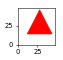

In [4]:
# Image and dataset size we are going to use
image_size = 48
dataset_size = 5000

# Create plot's figure and axes
# https://stackoverflow.com/a/638443
fig = plt.figure(figsize=(1,1), dpi=image_size)
ax = fig.add_subplot(111)

# Setting for the axes
ax.set_xlim(0,image_size)
ax.set_ylim(0,image_size)
# ax.axis('off')

# Draw a random shape
art = draw_shape(image_size,random.randint(0,2))
# Add the shape to the plot
# https://stackoverflow.com/a/29184075
plt.gcf().gca().add_artist(art)
# gcf() means Get Current Figure
# gca() means Get Current Axis

# convert the figure to an array
data = fig2rgb_array(fig)
print(data.shape)

Let's create a loop that will generate a small dataset for us

(5000, 48, 48, 3)
(5000,)


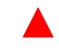

In [5]:
def generate_dataset(image_size, dataset_size):

    # Those variable will contain the images and associated labels
    images = np.zeros((dataset_size, image_size, image_size, 3))
    labels = np.zeros((dataset_size))
    
    # The plot figure we will use to generate the shapes
    fig = plt.figure(figsize=(1,1), dpi=image_size)

    for i in range(dataset_size):
        
        # Clear the figure
        fig.clf()
        
        # Recreate the axes
        ax = fig.add_subplot(111)
        ax.set_xlim(0, image_size)
        ax.set_ylim(0, image_size)
        ax.axis('off')
        
        # Define label
        label = i%3
        art = draw_shape(image_size, label)
        plt.gcf().gca().add_artist(art)
        
        # Add values to the arrays
        images[i] = fig2rgb_array(fig)
        labels[i] = label
        
    return images, labels

# Generate our dataset
images, labels = generate_dataset(image_size, dataset_size)
print(images.shape)
print(labels.shape)

Eventually we can save our dataset for later, since it takes quite some time to generate it 😉

In [6]:
# np.save('datasets/shape-example-shapes4.npy', images)
# np.save('datasets/shape-example-labels1.npy', labels)

If we need to load it we can then use the following code

In [8]:
images = np.load('datasets/shape-example-shapes1.npy')
labels = np.load('datasets/shape-example-labels1.npy')

We split our dataset manually in training and testing set

(4000, 48, 48, 3)
(4000,)


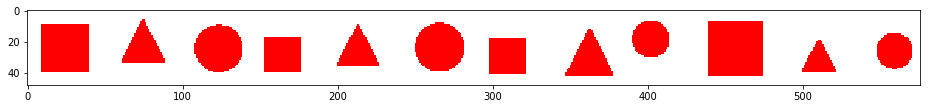

In [9]:
# Define the size of the training set, here we use 80% of the total samples for training
train_size = int(dataset_size*.8)

# TODO: We should shuffle the dataset

# Split the dataset into train and test dataset
train_images, test_images = images[:train_size], images[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# Verify the data
print(train_images.shape)
print(train_labels.shape)

# sample_images = []
# for label, image in list(zip(train_labels, train_images))[:10]:
#     fig1, ax1 = plt.subplots()
#     ax1.axis('off')
#     plt.title(label)
#     fig1.add_subplot(111).imshow(image/255)

full_image = np.concatenate(train_images[:12]/255, axis=1)
plt.figure(figsize=(16,4))
plt.imshow(full_image)

Now we can create our model

In [10]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='sigmoid', input_shape=(3 * image_size * image_size,)))
network.add(layers.Dense(3, activation='softmax'))

And compile it

In [11]:
network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in the `[0, 1]` interval. Then we also need to categorically encode the labels.

In [12]:
# Reshape data
train_images = train_images.reshape((len(train_images), 3 * image_size * image_size))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((len(test_images), 3 * image_size * image_size))
test_images = test_images.astype('float32') / 255

# Encode to categorical
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Then we can start the training

In [13]:
network.fit(train_images, train_labels, epochs=100, batch_size=128)

Epoch 1/100
4000/4000 [==============================] - 3s 632us/step - loss: 1.5652 - acc: 0.5182
Epoch 2/100
4000/4000 [==============================] - 2s 468us/step - loss: 0.7123 - acc: 0.6445
Epoch 3/100
4000/4000 [==============================] - 2s 470us/step - loss: 0.6019 - acc: 0.7332
Epoch 4/100
4000/4000 [==============================] - 2s 474us/step - loss: 0.5196 - acc: 0.8438
Epoch 5/100
4000/4000 [==============================] - 2s 470us/step - loss: 0.4150 - acc: 0.8932
Epoch 6/100
4000/4000 [==============================] - 2s 466us/step - loss: 0.3292 - acc: 0.9233
Epoch 7/100
4000/4000 [==============================] - 2s 470us/step - loss: 0.3009 - acc: 0.9105
Epoch 8/100
4000/4000 [==============================] - 2s 507us/step - loss: 0.2570 - acc: 0.9293
Epoch 9/100
4000/4000 [==============================] - 2s 513us/step - loss: 0.2219 - acc: 0.9375
Epoch 10/100
4000/4000 [==============================] - 2s 472us/step - loss: 0.2054 - acc: 0.9407

4000/4000 [==============================] - 2s 485us/step - loss: 0.0129 - acc: 0.9995
Epoch 80/100
4000/4000 [==============================] - 2s 468us/step - loss: 0.0109 - acc: 0.9995
Epoch 81/100
4000/4000 [==============================] - 2s 468us/step - loss: 0.0160 - acc: 0.9990
Epoch 82/100
4000/4000 [==============================] - 2s 472us/step - loss: 0.0105 - acc: 1.0000
Epoch 83/100
4000/4000 [==============================] - 2s 467us/step - loss: 0.0102 - acc: 1.0000
Epoch 84/100
4000/4000 [==============================] - 2s 468us/step - loss: 0.0094 - acc: 1.0000
Epoch 85/100
4000/4000 [==============================] - 2s 456us/step - loss: 0.0093 - acc: 1.0000
Epoch 86/100
4000/4000 [==============================] - 2s 443us/step - loss: 0.0125 - acc: 1.0000
Epoch 87/100
4000/4000 [==============================] - 2s 451us/step - loss: 0.0100 - acc: 1.0000
Epoch 88/100
4000/4000 [==============================] - 2s 439us/step - loss: 0.0087 - acc: 1.0000
Epo

In [14]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

1000/1000 [==============================] - 0s 210us/step


In [15]:
print('test_acc:', test_acc)

test_acc: 0.994


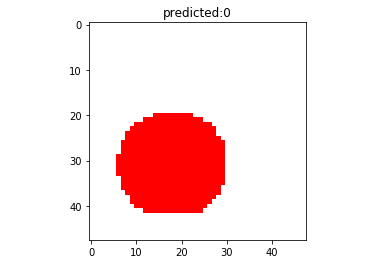

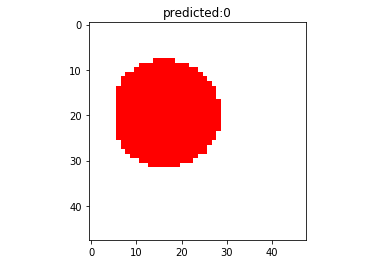

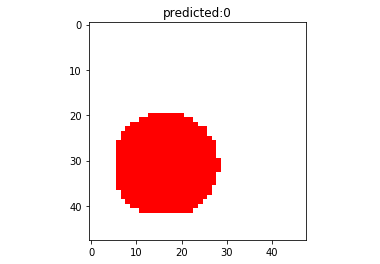

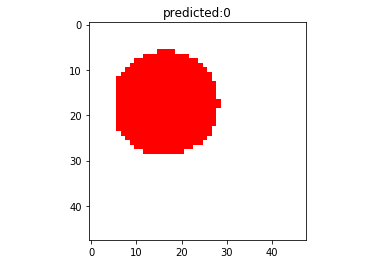

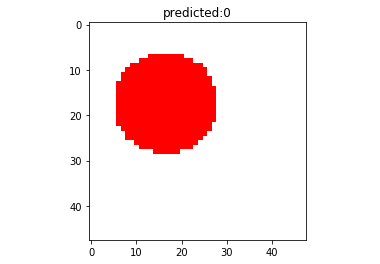

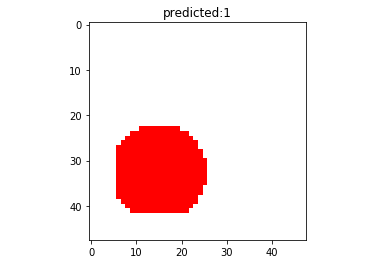

In [16]:
for label, image in list(zip(test_labels, test_images)):
    prediction = network.predict(np.array([image,]))
    if not prediction.argmax() == label.argmax():
        image = image.reshape(48, 48, 3)
        fig1, ax1 = plt.subplots()
        ax1.axis('off')
        plt.title('predicted:' + str(prediction.argmax()))
        fig1.add_subplot(111).imshow(image)    